In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute

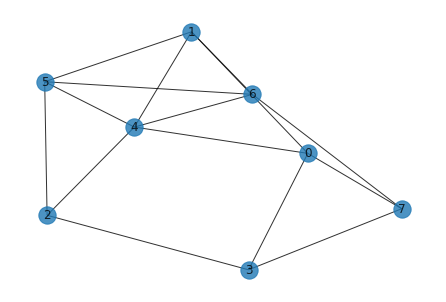

In [2]:
edges = [(0,1), (0,4), (0,3), (1,4), (1,5), (2,3), (2,4), (2,5), (4,5), (5,6), (6,7), (4,6), (3,7), (0,7), (1,6)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, alpha=0.8)

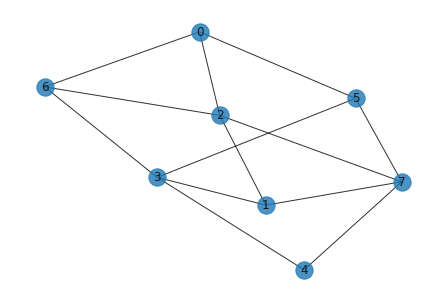

In [3]:
# function to find edges that don't exist
non_edges = []
for i in range(len(nx.nodes(G))):
    for j  in range(i):
        if i!=j :
            non_edges.append((j,i))
for i in range(len(edges)):
    non_edges.remove(edges[i])
non_G = nx.Graph(non_edges)
nx.draw(non_G, with_labels=True, alpha=0.8)

In [4]:
def max_clique(x, G):
    # x is the input bit string
    # Output will be the maxcut function value using x bit string
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj

In [5]:
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = max_clique(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [6]:
# BASIC QAOA FROM HERE

def create_qaoa_circ(G, theta):
    nqubits = len(G.nodes())
    nlayers = len(theta)//3  # number of alternating unitaries
    beta = theta[:nlayers]
    k = theta[nlayers:]
    alpha = k[:nlayers]
    gamma = k[nlayers:]

    qc = QuantumCircuit(nqubits)

    # initial_state
    qc.h(range(nqubits))

    for irep in range(nlayers):
        # problem unitary
        for i in range(nqubits):
            qc.rz(2 * alpha[irep], i)
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
        qc.barrier()
        # mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[irep], qubit)
        qc.barrier()

    qc.measure_all()
    return qc

def get_expectation_QAOA(graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)
    return execute_circ

In [7]:
# MULTI-ANGLE QAOA

def create_maqaoa_circ(G, theta):   
    nqubits = len(G.nodes()) 
    qc = QuantumCircuit(nqubits)
    clauses = len(G.edges())
    nlayers = len(theta)//((nqubits*2)+clauses)
    beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
    gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,nqubits+clauses))
    
    for i in range(nqubits):
        qc.h(i)
    
    for irep in range(nlayers):
        k=0
        # problem unitary
        for i in range(nqubits):
            qc.rz(2 * gamma[irep,k], i)
            k+=1
        
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep,k], pair[0], pair[1])
            k+=1
        qc.barrier()
        # mixer unitary
        for i in range(nqubits):
            qc.rx(2 * beta[irep,i], i)
        qc.barrier()
        
    qc.measure_all()
    return qc

def get_expectation_MAQAOA(G, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_maqaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, G)
    
    return execute_circ

In [29]:
# BASIC QAOA FROM HERE

In [ ]:
theta = [5,3,4,3,5,44,5,4,5,32,35,3,4,23,4]
print("Basic QAOA")
qc = create_qaoa_circ(non_G, theta)
qc.draw()

Basic QAOA


In [94]:
from scipy.optimize import minimize
expectation = get_expectation_QAOA(non_G)
res = minimize(expectation, theta, method='COBYLA')
print("Basic QAOA")
res

Basic QAOA


     fun: -7.630859375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 175
  status: 1
 success: True
       x: array([ 6.21407679,  3.0844471 ,  4.11021342,  3.87522132,  5.00006833,
       43.82869407,  5.00208808,  3.92399469,  4.88032804, 32.12725428,
       35.26676423,  3.24089103,  3.84856164, 23.10344893,  4.99883376])

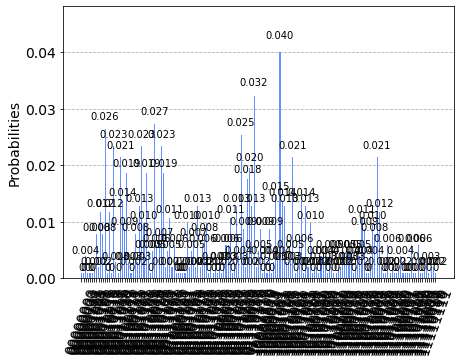

In [95]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(non_G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

In [26]:
# MULTI-ANGLE QAOA FROM HERE

Multi-Angle QAOA


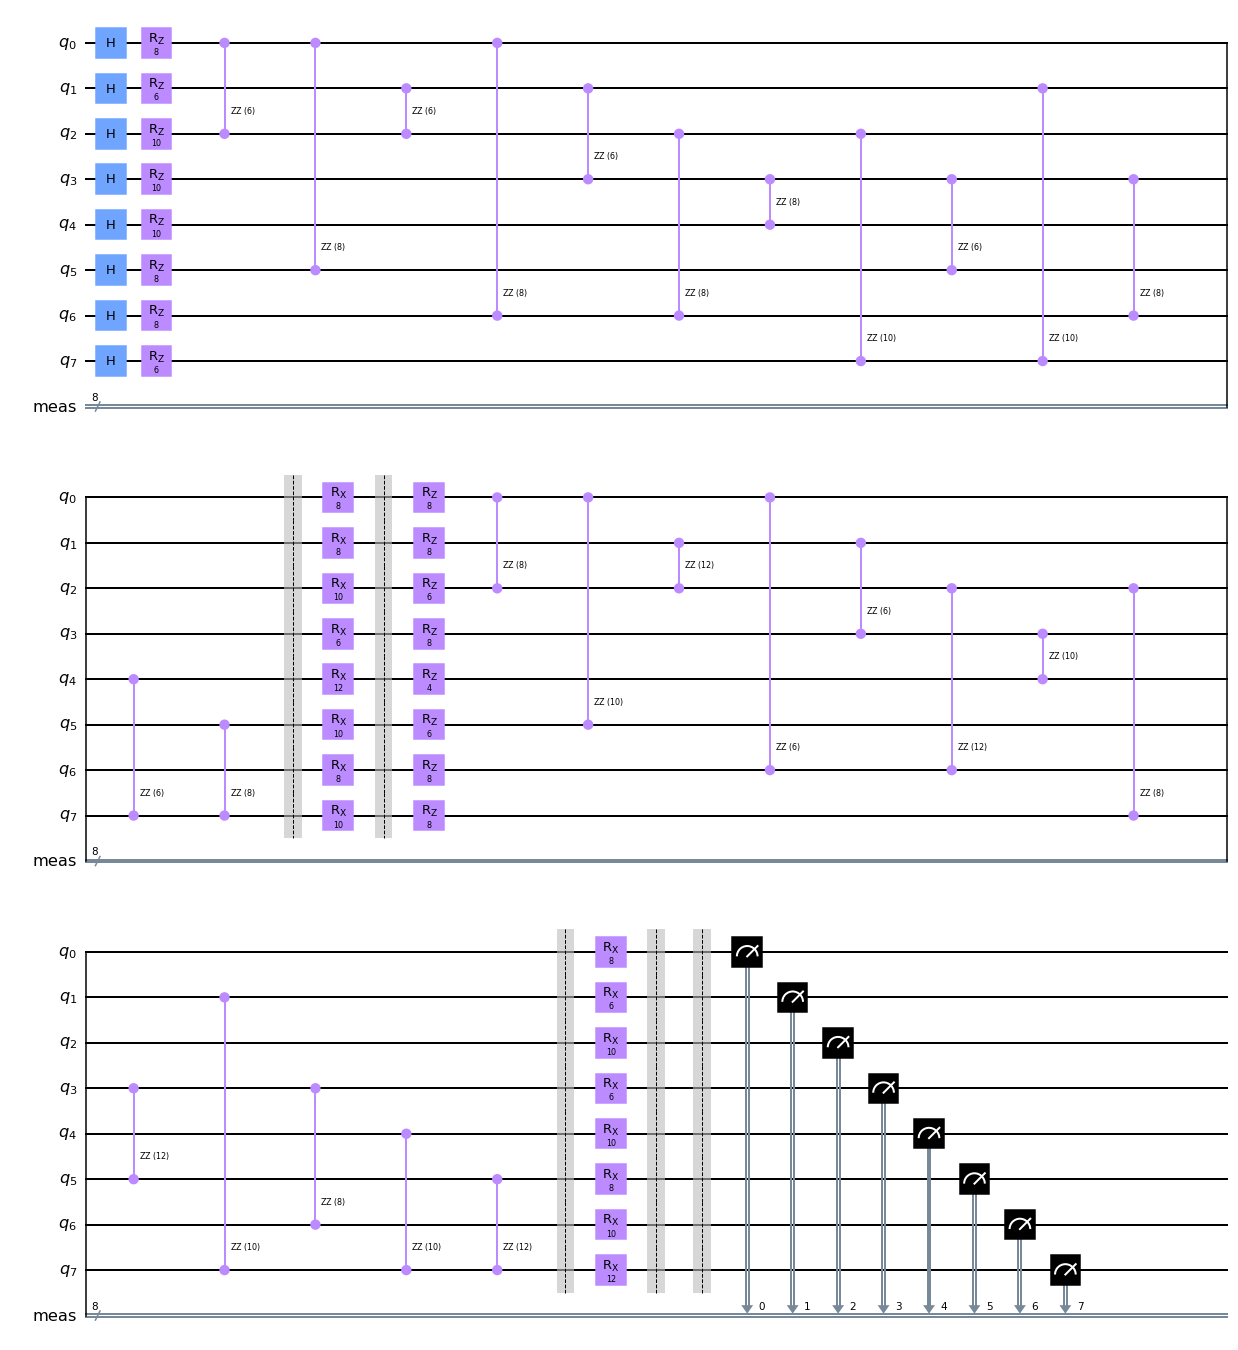

In [54]:
# Adding Parameters
beta = np.array([[4,4,5,3,6,5,4,5], [4,3,5,3,5,4,5,6]]) #Edit as per the number of qubits
gamma = np.array([[4,3,5,5,5,4,4,3,3,4,4,3,4,5,3,5,4,3,4,3,4],[4,4,3,4,2,3,4,4,4,5,3,6,6,4,3,5,5,6,4,5,6]]) #Edit as per the number of (qubits + the combination nC2 - number of edges)
theta = np.concatenate((beta.flatten(), gamma.flatten()))

qc = create_maqaoa_circ(non_G, theta)
print("Multi-Angle QAOA")
qc.draw()

In [55]:
from scipy.optimize import minimize
expectation = get_expectation_MAQAOA(non_G)
res = minimize(expectation, theta, method='COBYLA')
print("Multi-Angle QAOA")
res

Multi-Angle QAOA


     fun: -10.9091796875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 967
  status: 1
 success: True
       x: array([4.63683032, 5.28380287, 5.49182298, 3.05955368, 5.41930693,
       4.8739079 , 4.80441658, 4.76894872, 3.87830866, 1.86002193,
       6.229459  , 3.87941453, 4.62710425, 4.94876831, 5.492583  ,
       6.2904956 , 4.00474763, 4.52030439, 4.76166249, 6.29913426,
       4.6819006 , 4.20621557, 3.74261601, 3.29417033, 3.13932892,
       4.23525002, 4.11819711, 3.14705802, 4.68322629, 5.53483465,
       3.18541051, 5.36513765, 4.63115472, 3.08903598, 4.63354754,
       2.32589778, 4.59700018, 4.02017584, 4.28011927, 2.91799566,
       4.66598588, 1.61904334, 3.82956438, 3.61345723, 3.68946497,
       3.98003666, 5.19894917, 3.76894894, 6.47801968, 5.55320655,
       3.71753171, 3.23612298, 5.16935274, 4.04791428, 6.25779535,
       4.63536636, 4.55594975, 6.13032457])

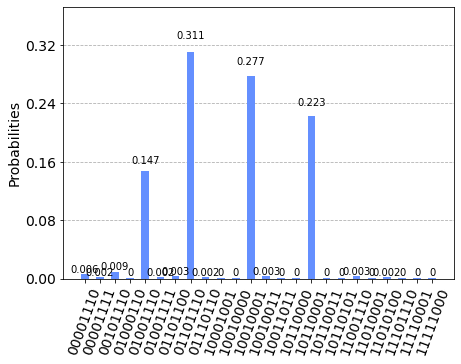

In [57]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_maqaoa_circ(non_G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)